In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
# import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

2024-12-30 13:47:02.852127: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-30 13:47:03.095224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735562823.166846    2334 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735562823.231261    2334 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 13:47:03.452019: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [4]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(train_dir, (IMG_HEIGHT, IMG_WIDTH), class_mode="binary", batch_size=batch_size)
val_data_gen = validation_image_generator.flow_from_directory(validation_dir, (IMG_HEIGHT, IMG_WIDTH), class_mode="binary", batch_size=batch_size)
test_data_gen = test_image_generator.flow_from_directory(test_dir, (IMG_HEIGHT, IMG_WIDTH), classes=['.'], class_mode="binary", batch_size=batch_size, shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


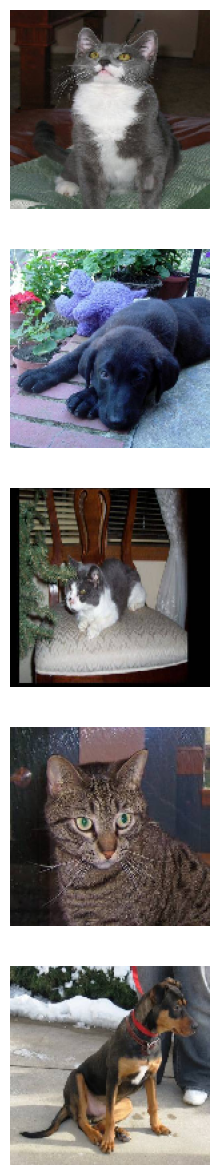

In [5]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [6]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    zoom_range=0.3,
    brightness_range=(0.3, 0.7),
    width_shift_range=0.2,
    height_shift_range=0.2)


Found 2000 images belonging to 2 classes.


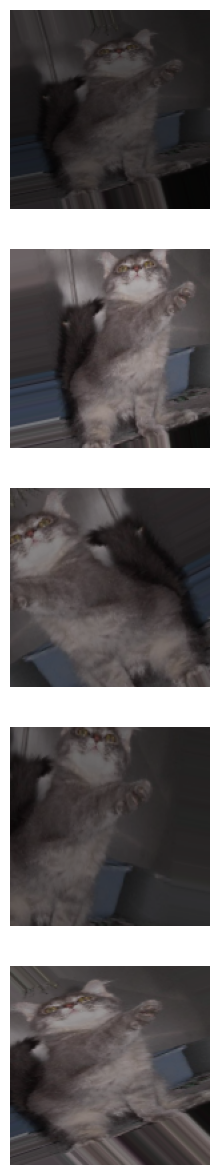

In [7]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [17]:
# 7
model = Sequential([
    keras.Input((IMG_WIDTH, IMG_HEIGHT, 3)),

    Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D(),

    Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D(),

    Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPooling2D(),

    Flatten(),
    Dense(units=10, activation="relu"),
    Dense(units=1, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │       829,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,200,277 (4.58 MB)

 Trainable params: 1,200,277 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
 # 8
history = model.fit(train_data_gen, validation_data=val_data_gen, epochs=epochs, steps_per_epoch=int(np.ceil(total_train / batch_size)))


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 713ms/step - accuracy: 0.5248 - loss: 0.6881 - val_accuracy: 0.5270 - val_loss: 0.6719
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 659ms/step - accuracy: 0.5084 - loss: 0.6884 - val_accuracy: 0.5580 - val_loss: 0.6973
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 688ms/step - accuracy: 0.5982 - loss: 0.6584 - val_accuracy: 0.6090 - val_loss: 0.6581
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 669ms/step - accuracy: 0.6268 - loss: 0.6335 - val_accuracy: 0.6010 - val_loss: 0.7483
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 683ms/step - accuracy: 0.6291 - loss: 0.6377 - val_accuracy: 0.6090 - val_loss: 0.6709
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 688ms/step - accuracy: 0.6459 - loss: 0.6205 - val_accuracy: 0.6440 - val_loss: 0.6593
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 705ms/step - accuracy: 0.6340 - loss: 0.6244 - val_accuracy: 0.6730 - val_loss: 0.6239
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 793ms/step - accuracy: 0.6760 - loss: 0.6124 - val_accu

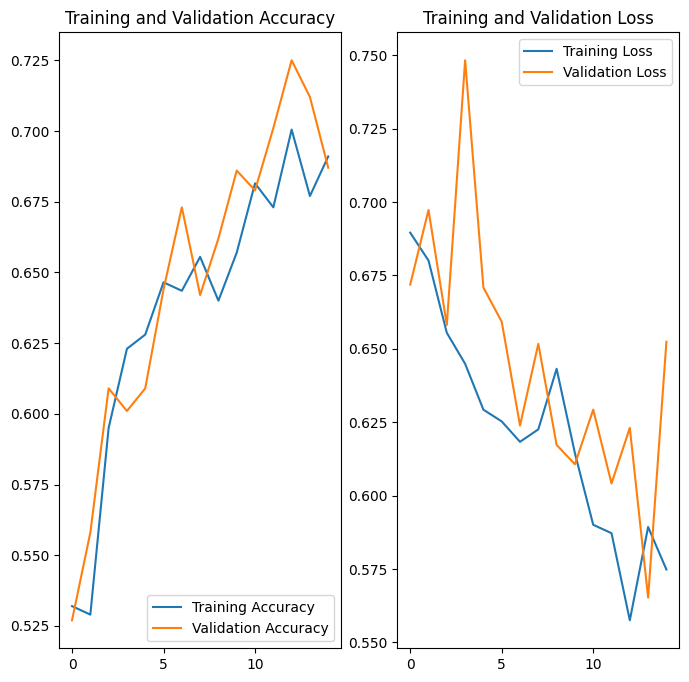

In [19]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/tmp/ipykernel_2334/2658126605.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
/tmp/ipykernel_2334/2658126605.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % (probability*100) + "% dog")


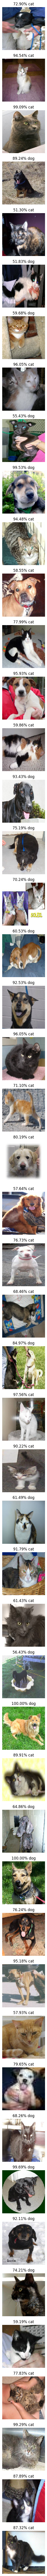

In [20]:
# 10
probabilities = model.predict(test_data_gen)
sample_test_images, _ = next(test_data_gen)
plotImages(sample_test_images, probabilities)

In [21]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
